In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys, os, re, glob
import bs4
from bs4 import BeautifulSoup
from lxml import etree
import scipy.ndimage as ndi
from webdataset import WebDataset
from webdataset.writer import TarWriter
import itertools as itt
import io
figsize(12, 12)

In [3]:
def get_text(node):
    textnodes = node.xpath('.//text()')
    s = ''.join([text for text in textnodes])
    return re.sub(r'\s+', ' ', s)


def get_prop(node, name):
    title = node.get("title")
    props = title.split(';')
    for prop in props:
        (key, args) = prop.split(None, 1)
        args = args.strip('"')
        if key == name:
            return args
    return None

In [17]:
book = itt.islice(WebDataset("gs://lpr-g1000-tess/Volume_0020.tgz", opener="gsutil cat '{}'", extensions="jpeg hocr"), 40, 10000)
image, hocr = next(iter(book))

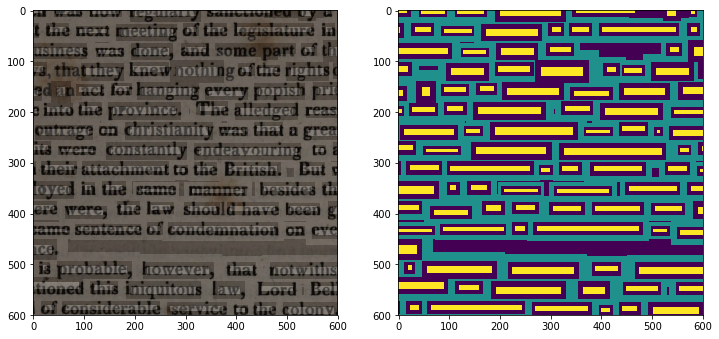

In [18]:
def target_for_page(image, hocr):
    htmlparser = etree.HTMLParser()
    doc = etree.parse(io.BytesIO(hocr), htmlparser)
    pages = list(doc.xpath('//*[@class="ocr_page"]'))
    assert len(pages)==1
    page = pages[0]
    h, w = image.shape[:2]
    _, _, w1, h1 = [int(x) for x in get_prop(page, 'bbox').split()]
    if h1!=h or w1!=w:
        print(f"image and page dimensions differ ({h}, {w}) != ({h1}, {w1})")
    target = zeros((h, w), dtype="uint8")
    #print(page.get("title"))
    for word in page.xpath("//*[@class='ocrx_word']"):
        x0, y0, x1, y1 = [int(x) for x in get_prop(word, 'bbox').split()]
        bw, bh = x1-x0, y1-y0
        if bw<10 or bw>1000 or bh<10 or bh>100: continue
        xc, yc = int(mean([x0, x1])), int(mean([y0, y1]))
        a = int(bh*0.4)
        target[y0-a:y1+a, x0-a:x1+a] = 1
    for word in page.xpath("//*[@class='ocrx_word']"):
        x0, y0, x1, y1 = [int(x) for x in get_prop(word, 'bbox').split()]
        bw, bh = x1-x0, y1-y0
        if bw<10 or bw>1000 or bh<10 or bh>100: continue
        xc, yc = int(mean([x0, x1])), int(mean([y0, y1]))
        b = int(-bh*0.05)
        target[y0-b:y1+b, x0-b:x1+b] = 0
    for word in page.xpath("//*[@class='ocrx_word']"):
        x0, y0, x1, y1 = [int(x) for x in get_prop(word, 'bbox').split()]
        bw, bh = x1-x0, y1-y0
        if bw<10 or bw>1000 or bh<10 or bh>100: continue
        xc, yc = int(mean([x0, x1])), int(mean([y0, y1]))
        c = int(bh*0.2)
        d = int(bh*0.3)
        target[yc-c:yc+c, x0+d:x1-d] = 2
    return target
target = target_for_page(image, hocr)
subplot(121); imshow(image[200:800, 200:800]*0.5+0.1*target[200:800, 200:800, newaxis])
subplot(122); imshow(target[200:800, 200:800])

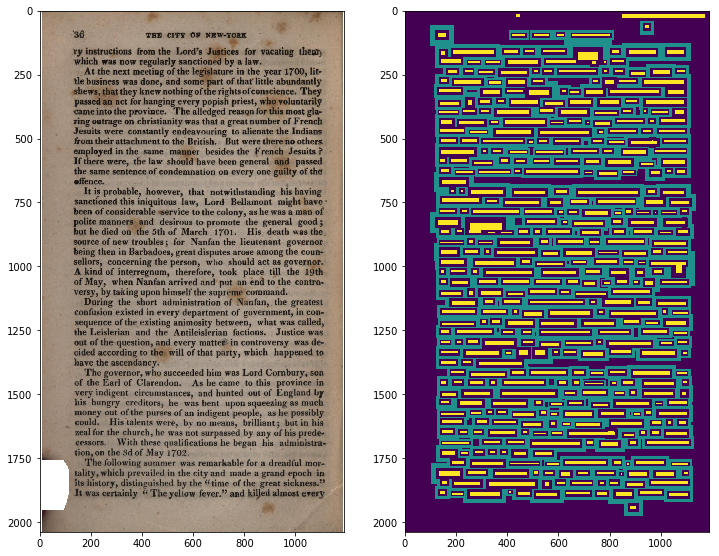

In [19]:
subplot(121); imshow(image)
subplot(122); imshow(target)

In [20]:
def interesting_patches(sensor, threshold, images, r=256, n=50):
    h, w = image.shape[:2]
    count = 0
    for i in range(200):
        if count >= n: break
        y = randint(0, h-r-1)
        x = randint(0, w-r-1)
        patch = sensor[y:y+r, x:x+r]
        if mean(patch)<threshold: continue
        patches = [a[y:y+r, x:x+r] for a in images]
        yield [i] + patches + [(x, y)]
        count += 1

In [25]:
for volume in range(200):
    book = WebDataset(f"gs://lpr-g1000-tess/Volume_{volume:04d}.tgz",
                      opener="gsutil cat '{}'",
                      extensions="__key__ jpeg hocr")
    book = itt.islice(book, 30, 130)
    with open(f"segmentation-{volume:04d}.tar", "wb") as stream:
        with TarWriter(stream) as sink:
            for key, image, hocr in book:
                print(key, flush=True, end=" ", file=sys.stderr)
                target = target_for_page(image, hocr)
                for i, ipatch, tpatch, (x, y) in interesting_patches(target, 0.1, [image, target]):
                    sink.dwrite(key+f"/{x},{y}", image_png=ipatch, target_png=tpatch)

Volume_0000/Image_0030 Volume_0000/Image_0031 Volume_0000/Image_0032 Volume_0000/Image_0033 Volume_0000/Image_0034 Volume_0000/Image_0035 Volume_0000/Image_0036 Volume_0000/Image_0037 Volume_0000/Image_0038 Volume_0000/Image_0039 Volume_0000/Image_0040 Volume_0000/Image_0041 Volume_0000/Image_0042 Volume_0000/Image_0043 Volume_0000/Image_0044 Volume_0000/Image_0045 Volume_0000/Image_0046 Volume_0000/Image_0047 Volume_0000/Image_0048 Volume_0000/Image_0049 Volume_0000/Image_0050 Volume_0000/Image_0051 Volume_0000/Image_0052 Volume_0000/Image_0053 Volume_0000/Image_0054 Volume_0000/Image_0055 Volume_0000/Image_0056 Volume_0000/Image_0057 Volume_0000/Image_0058 Volume_0000/Image_0059 Volume_0000/Image_0060 Volume_0000/Image_0061 Volume_0000/Image_0062 Volume_0000/Image_0063 Volume_0000/Image_0064 Volume_0000/Image_0065 Volume_0000/Image_0066 Volume_0000/Image_0067 Volume_0000/Image_0068 Volume_0000/Image_0069 Volume_0000/Image_0070 Volume_0000/Image_0071 Volume_0000/Image_0072 Volume_0000

In [ ]:
!tarpcat -p 200 -s 1000 segmentation/segmentation-????.tar | tarsplit -s 1e8 -o seg --maxshards 20

# got 200 files
# started 200 jobs
# writing seg-000000.tar (0, 0)
# writing seg-000001.tar (1218, 100003904)
# writing seg-000002.tar (2419, 200078493)
# writing seg-000003.tar (3626, 300112333)
# writing seg-000004.tar (4831, 400141623)
# writing seg-000005.tar (6026, 500193715)
# writing seg-000006.tar (7229, 600193826)
# writing seg-000007.tar (8452, 700240168)
# writing seg-000008.tar (9643, 800274410)
# writing seg-000009.tar (10857, 900344777)
# writing seg-000010.tar (12063, 1000390094)
# writing seg-000011.tar (13268, 1100416423)
# writing seg-000012.tar (14452, 1200452197)
# writing seg-000013.tar (15644, 1300453988)
# writing seg-000014.tar (16855, 1400468314)
# writing seg-000015.tar (18043, 1500479286)
# writing seg-000016.tar (19243, 1600527275)
# writing seg-000017.tar (20465, 1700551345)
# writing seg-000018.tar (21680, 1800571988)
# writing seg-000019.tar (22879, 1900609402)
Traceback (most recent call last):
  File "/usr/local/bin/tarpcat", line 145, in <module>
    s